In [2]:
%pip install pyspark 
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, count, approx_count_distinct, when
from pyspark.sql.types import IntegerType, DoubleType
import pyspark.sql.functions as F

# Set JAVA_HOME environment variable (update the path to your Java installation)
os.environ["JAVA_HOME"] = "C:\\Program Files\\OpenLogic\\jdk-11.0.26.4-hotspot"  # Replace with your Java path
os.environ["PATH"] = os.environ["JAVA_HOME"] + "\\bin;" + os.environ["PATH"]

# Khởi tạo Spark Session
spark = SparkSession.builder \
    .appName("HMDA EDA with PySpark") \
    .getOrCreate()

# Đọc dữ liệu
df = spark.read.csv("data_fixed_3.csv", header=True, inferSchema=True)
df = df.sample(withReplacement=False, fraction=0.15, seed=42)

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/317.2 MB ? eta -:--:--
     - ------------------------------------- 8.9/317.2 MB 61.4 MB/s eta 0:00:06
     --- ---------------------------------- 26.2/317.2 MB 69.2 MB/s eta 0:00:05
     ---- --------------------------------- 38.5/317.2 MB 64.4 MB/s eta 0:00:05
     ----- -------------------------------- 43.8/317.2 MB 54.6 MB/s eta 0:00:06
     ----- -------------------------------- 49.3/317.2 MB 49.0 MB/s eta 0:00:06
     ------ ------------------------------- 55.3/317.2 MB 45.2 MB/s eta 0:00:06
     ------- ------------------------------ 61.1/317.2 MB 42.8 MB/s eta 0:00:06
     -------- ----------------------------- 67.4/317.2 MB 40.5 MB/s eta 0:00:07
     -------- ----------------------------- 73.1/317.2 MB 39.2 MB/s eta 0:00:07
     --------- ---------------------------- 79.2/317.2 MB 38.2 MB/s eta 0:00:07
     ---------- --------------------------- 85.5/

PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

In [ ]:
df.head()

Row(activity_year=2023, action_taken=1, purchaser_type=71, loan_type=2, loan_purpose=1, lien_status=1, loan_amount=245000.0, loan_to_value_ratio='96.5', interest_rate=7.125, rate_spread=1.7, total_loan_costs=3375.45, total_points_and_fees=0.0, origination_charges=4334.89, discount_points=2444.89, loan_term=360.0, property_value='245000', construction_method=1, occupancy_type=1, manufactured_home_secured_property_type=3, manufactured_home_land_property_interest=5, total_units='1', income=77.0, debt_to_income_ratio=None, applicant_credit_score_type=2, co-applicant_credit_score_type=10, applicant_ethnicity-1=2.0, co-applicant_ethnicity-1=5.0, applicant_race-1=3.0, co-applicant_race-1=8.0, applicant_age='35-44', co-applicant_age='9999', applicant_age_above_62='No', co-applicant_age_above_62='No Co-Applicant', aus-1=1, denial_reason-1=10, ltv_category='High', dti_category='Missing', loan_term_category='Long')

In [ ]:
#1 Kiểm tra cấu trúc dữ liệu
df.printSchema()
df.summary().show()
df.show(5)

root
 |-- activity_year: integer (nullable = true)
 |-- action_taken: integer (nullable = true)
 |-- purchaser_type: integer (nullable = true)
 |-- loan_type: integer (nullable = true)
 |-- loan_purpose: integer (nullable = true)
 |-- lien_status: integer (nullable = true)
 |-- loan_amount: double (nullable = true)
 |-- loan_to_value_ratio: string (nullable = true)
 |-- interest_rate: double (nullable = true)
 |-- rate_spread: double (nullable = true)
 |-- total_loan_costs: double (nullable = true)
 |-- total_points_and_fees: double (nullable = true)
 |-- origination_charges: double (nullable = true)
 |-- discount_points: double (nullable = true)
 |-- loan_term: double (nullable = true)
 |-- property_value: string (nullable = true)
 |-- construction_method: integer (nullable = true)
 |-- occupancy_type: integer (nullable = true)
 |-- manufactured_home_secured_property_type: integer (nullable = true)
 |-- manufactured_home_land_property_interest: integer (nullable = true)
 |-- total_uni

+-------+------------------+-----------------+--------------------+------------------+------------+---------------------------+-------------+
|summary|       loan_amount|    interest_rate|debt_to_income_ratio|            income|ltv_category|applicant_credit_score_type|applicant_age|
+-------+------------------+-----------------+--------------------+------------------+------------+---------------------------+-------------+
|  count|           1235546|          1235546|              536122|           1235546|     1235546|                    1235546|      1235546|
|   mean| 287050.7047086875|8.997768274227226|   42.75389929904014|149.93121907237773|        NULL|          37.09835570670781|       8888.0|
| stddev|1702022.0869682725|3.700873515002515|   3.973810425125151| 5508.684637418561|        NULL|         188.73818539335898|          0.0|
|    min|            5000.0|              0.0|                36.0|          -41730.0|        High|                          1|        25-34|
|    2

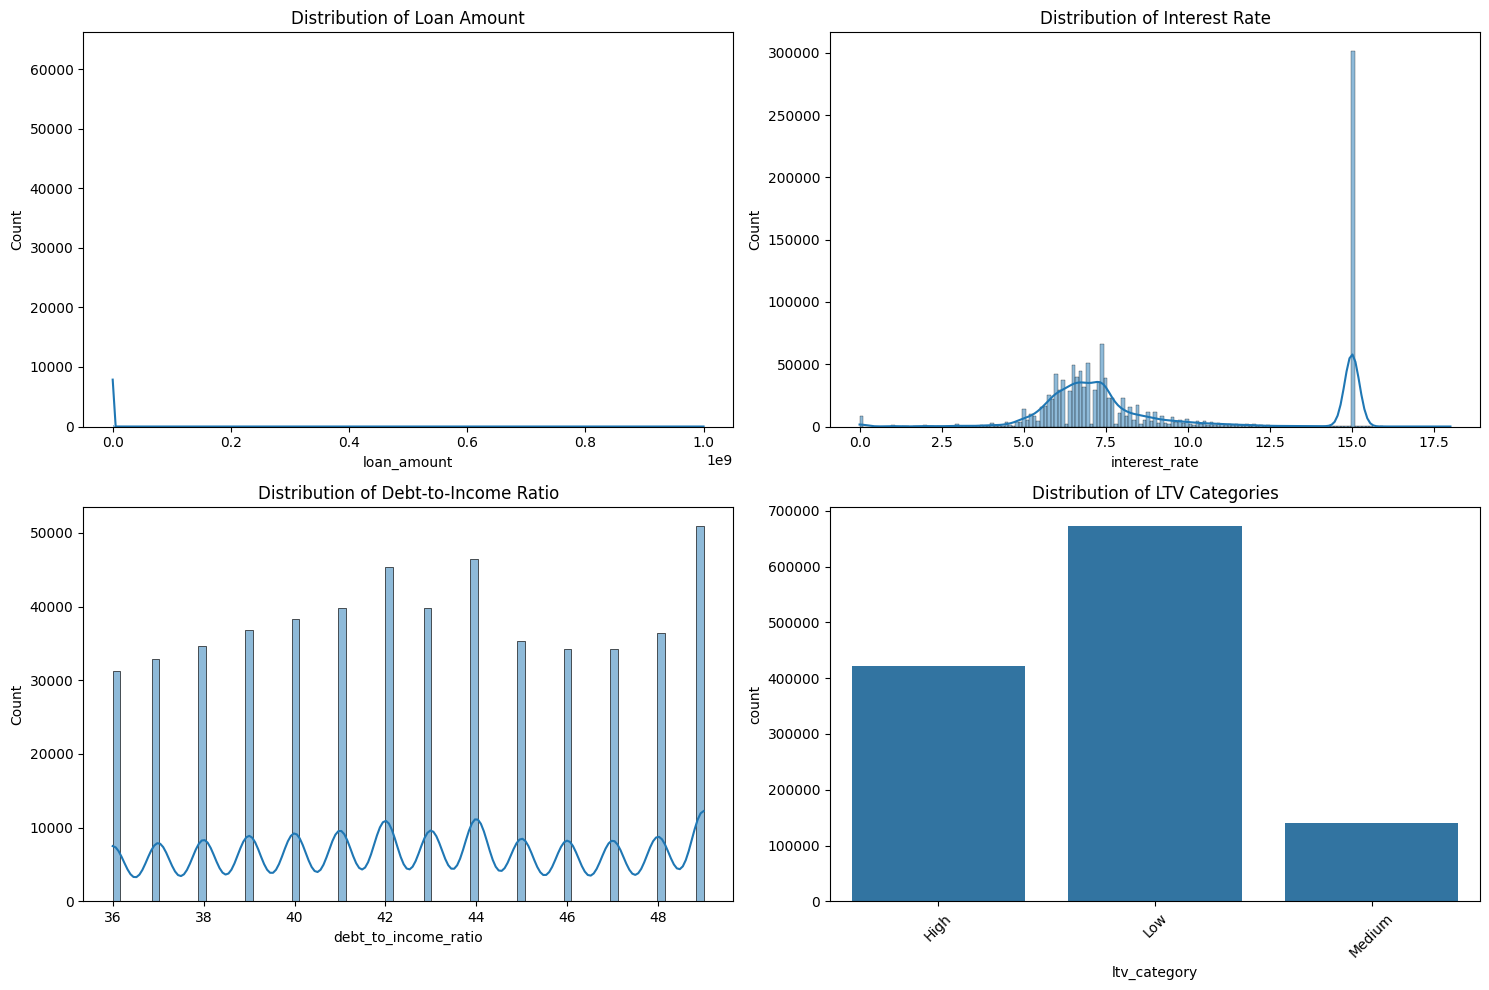

+-----------+------+-----------------+-----------------+------------------------+
| risk_group| count|  avg_loan_amount|avg_interest_rate|most_common_ltv_category|
+-----------+------+-----------------+-----------------+------------------------+
|   Low Risk| 31190|263932.9913433793|8.114838986854805|                     Low|
|Medium Risk|267605|274874.7033874554|8.129734919003699|                     Low|
|  High Risk|936751|291298.7923151403|9.275140415274633|                     Low|
+-----------+------+-----------------+-----------------+------------------------+



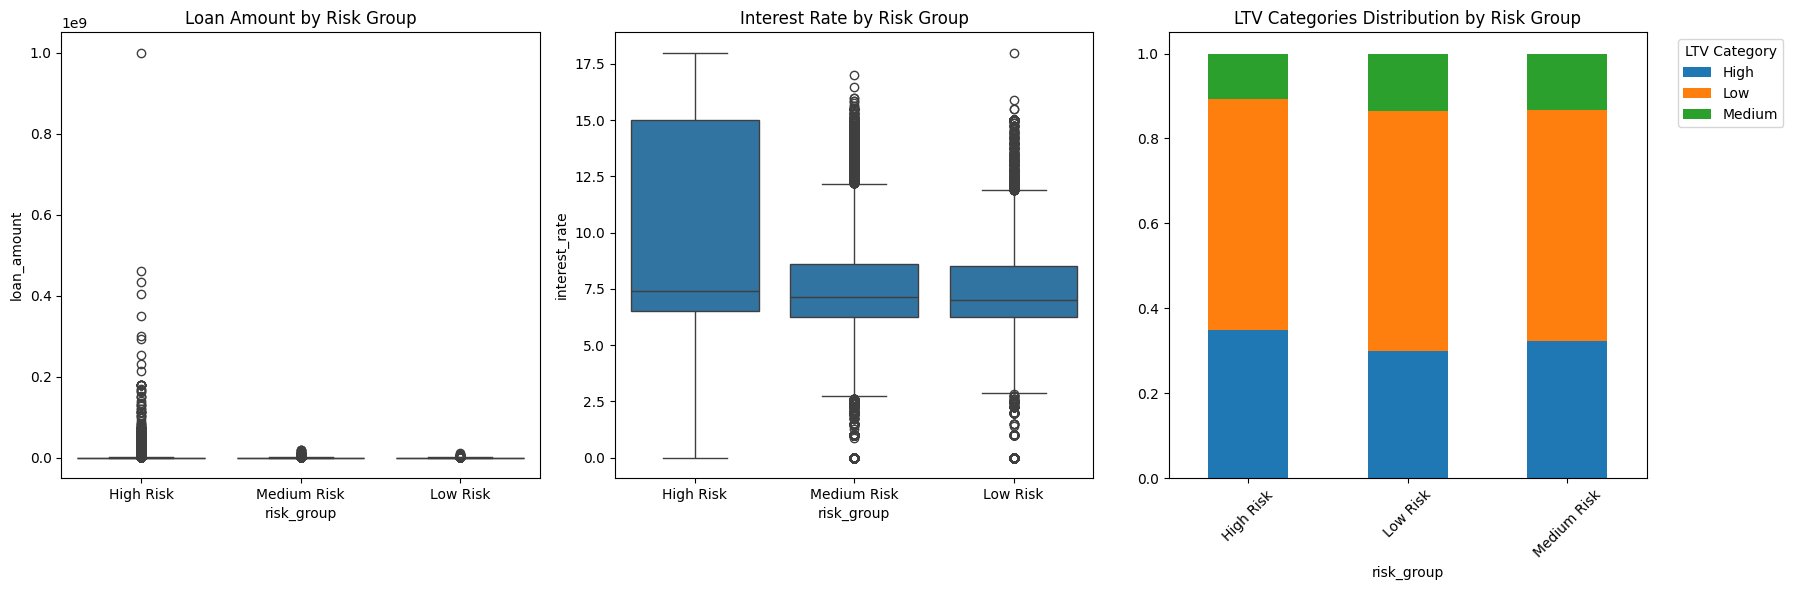

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, mean, count, when

# Các biến phân tích tín dụng 
credit_vars = ['loan_amount', 'interest_rate', 'debt_to_income_ratio', 'income', 
               'ltv_category', 'applicant_credit_score_type', 'applicant_age']

# Thống kê mô tả cho các biến số
df.select(credit_vars).summary().show()

# Chuyển sang pandas để vẽ biểu đồ
pd_df = df.select(credit_vars).toPandas()

# Tạo subplot cho các biến số
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loan Amount Distribution
sns.histplot(data=pd_df, x='loan_amount', kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of Loan Amount')

# Interest Rate Distribution
sns.histplot(data=pd_df, x='interest_rate', kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribution of Interest Rate')

# DTI Distribution
sns.histplot(data=pd_df, x='debt_to_income_ratio', kde=True, ax=axes[1,0])
axes[1,0].set_title('Distribution of Debt-to-Income Ratio')

# LTV Categories Distribution
sns.countplot(data=pd_df, x='ltv_category', ax=axes[1,1])
axes[1,1].set_title('Distribution of LTV Categories')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Phân tích theo nhóm rủi ro
df = df.withColumn('risk_group',
    when(col('debt_to_income_ratio') <= 36, 'Low Risk')
    .when((col('debt_to_income_ratio') > 36) & (col('debt_to_income_ratio') <= 43), 'Medium Risk')
    .otherwise('High Risk'))

# Thống kê theo nhóm rủi ro
risk_stats = df.groupBy('risk_group').agg(
    count('*').alias('count'),
    mean('loan_amount').alias('avg_loan_amount'),
    mean('interest_rate').alias('avg_interest_rate'),
    F.mode('ltv_category').alias('most_common_ltv_category')
)
risk_stats.show()

# Visualize phân phối theo nhóm rủi ro
pd_risk = df.select('risk_group', 'loan_amount', 'interest_rate', 'ltv_category').toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loan Amount by Risk Group
sns.boxplot(data=pd_risk, x='risk_group', y='loan_amount', ax=axes[0])
axes[0].set_title('Loan Amount by Risk Group')

# Interest Rate by Risk Group
sns.boxplot(data=pd_risk, x='risk_group', y='interest_rate', ax=axes[1])
axes[1].set_title('Interest Rate by Risk Group')

# LTV Categories by Risk Group
ltv_risk_crosstab = pd.crosstab(pd_risk['risk_group'], pd_risk['ltv_category'], normalize='index')
ltv_risk_crosstab.plot(kind='bar', stacked=True, ax=axes[2])
axes[2].set_title('LTV Categories Distribution by Risk Group')
axes[2].legend(title='LTV Category', bbox_to_anchor=(1.05, 1))
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

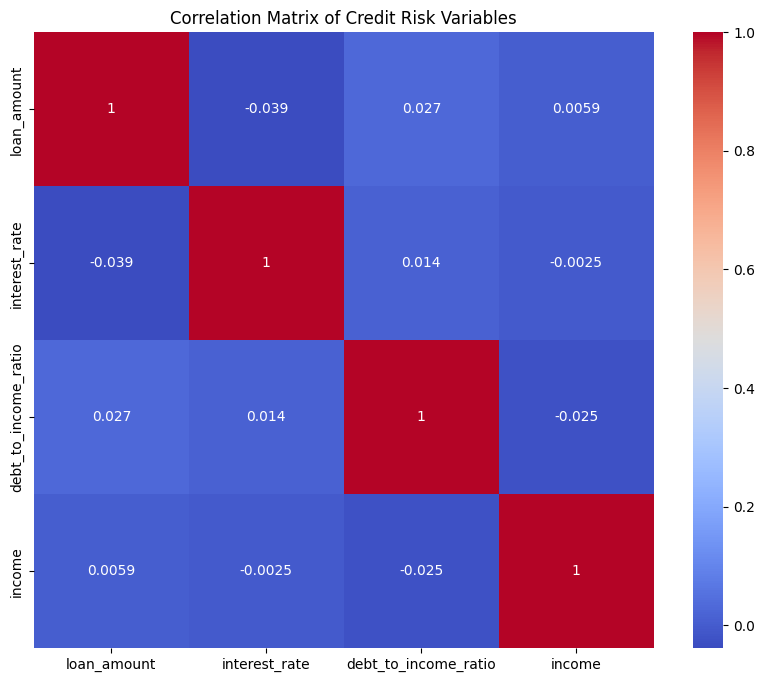

In [ ]:
# Tạo correlation matrix cho các biến số
numeric_vars = ['loan_amount', 'interest_rate', 'debt_to_income_ratio', 'income']
pd_numeric = df.select(numeric_vars).toPandas()

plt.figure(figsize=(10, 8))
sns.heatmap(pd_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Credit Risk Variables')
plt.show()

In [ ]:
# Biểu đồ phân tích theo nhóm tuổi
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loan Amount by Age Group
sns.boxplot(data=pd_df, x='applicant_age', y='loan_amount', ax=axes[0,0])
axes[0,0].set_title('Loan Amount by Age Group')
axes[0,0].tick_params(axis='x', rotation=45)

# Interest Rate by Age Group
sns.boxplot(data=pd_df, x='applicant_age', y='interest_rate', ax=axes[0,1])
axes[0,1].set_title('Interest Rate by Age Group')
axes[0,1].tick_params(axis='x', rotation=45)

# Income Distribution
sns.histplot(data=pd_df, x='income', kde=True, ax=axes[1,0])
axes[1,0].set_title('Income Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Phân tích theo loan type và loan purpose
loan_analysis = df.groupBy('loan_type', 'loan_purpose').agg(
    count('*').alias('count'),
    mean('interest_rate').alias('avg_interest_rate'),
    mean('loan_amount').alias('avg_loan_amount')
).toPandas()

# Visualize loan type và purpose
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Loan Type Distribution
sns.barplot(data=loan_analysis, x='loan_type', y='count', ax=axes[0])
axes[0].set_title('Distribution of Loan Types')
axes[0].tick_params(axis='x', rotation=45)

# Loan Purpose Distribution
sns.barplot(data=loan_analysis, x='loan_purpose', y='avg_interest_rate', ax=axes[1])
axes[1].set_title('Average Interest Rate by Loan Purpose')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Credit Score Type Analysis
credit_score_analysis = df.groupBy('applicant_credit_score_type', 'risk_group').agg(
    count('*').alias('count'),
    mean('interest_rate').alias('avg_interest_rate')
).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=credit_score_analysis, 
            x='applicant_credit_score_type', 
            y='avg_interest_rate', 
            hue='risk_group')
plt.title('Average Interest Rate by Credit Score Type and Risk Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()